In [1]:

import os
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
%matplotlib inline

In [4]:
cf_train=pd.read_csv('counterfeit_train.csv')
cf_test=pd.read_csv('counterfeit_test.csv')

In [5]:

cf_test['Counterfeit_Sales']=np.nan
cf_train['data']='train'
cf_test['data']='test'
cf_test=cf_test[cf_train.columns]
cf_all=pd.concat([cf_train,cf_test],axis=0,ignore_index=True)

In [6]:
cf_all.head(5)

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales,data
0,RRA15,13.100,Area046,1995,160.2366,Antimalarial,critical,0.070422,DownTown,Tier 1,Small,1775.5026,train
1,YVV26,NaN,Area027,1983,110.4384,Mstablizers,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520,train
2,LJC15,9.025,Area046,1995,259.4092,Cardiac,mild,0.060783,DownTown,Tier 1,Small,2603.0920,train
3,GWC40,11.800,Area046,1995,99.9830,OralContraceptives,mild,0.065555,DownTown,Tier 1,Small,1101.7130,train
4,QMN13,NaN,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402,train


In [7]:
cf_all.dtypes

Medicine_ID             object
Counterfeit_Weight     float64
DistArea_ID             object
Active_Since             int64
Medicine_MRP           float64
Medicine_Type           object
SidEffect_Level         object
Availability_rating    float64
Area_Type               object
Area_City_Type          object
Area_dist_level         object
Counterfeit_Sales      float64
data                    object
dtype: object

In [8]:
cf_all['SidEffect_Level'].value_counts()

mild        5517
critical    3006
Name: SidEffect_Level, dtype: int64

In [9]:
cf_all['sideffect']=np.where(cf_all['SidEffect_Level']=='mild',1,0)
cf_all=cf_all.drop('SidEffect_Level',axis=1)

In [10]:
cf_all['Area_Type'].value_counts()

DownTown              5577
MidTownResidential    1083
CityLimits             935
Industrial             928
Name: Area_Type, dtype: int64

In [11]:
cf_all['DT']=np.where(cf_all['Area_Type']=='DownTown',1,0)
cf_all['MTR']=np.where(cf_all['Area_Type']=='MidTownResidential',1,0)
cf_all['AreaName']=np.where(cf_all['Area_Type']=='CityLimits',1,0)
cf_all=cf_all.drop('Area_Type',axis=1)

In [12]:
cf_all.dtypes

Medicine_ID             object
Counterfeit_Weight     float64
DistArea_ID             object
Active_Since             int64
Medicine_MRP           float64
Medicine_Type           object
Availability_rating    float64
Area_City_Type          object
Area_dist_level         object
Counterfeit_Sales      float64
data                    object
sideffect                int32
DT                       int32
MTR                      int32
AreaName                 int32
dtype: object

In [13]:

cf_all['Area_City_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Area_City_Type, dtype: int64

In [14]:
cf_all['T3']=np.where(cf_all['Area_City_Type']=='Tier 3',1,0)
cf_all['T2']=np.where(cf_all['Area_City_Type']=='Tier 2',1,0)
cf_all=cf_all.drop(['Area_City_Type'],axis=1)

In [15]:
cf_all.dtypes

Medicine_ID             object
Counterfeit_Weight     float64
DistArea_ID             object
Active_Since             int64
Medicine_MRP           float64
Medicine_Type           object
Availability_rating    float64
Area_dist_level         object
Counterfeit_Sales      float64
data                    object
sideffect                int32
DT                       int32
MTR                      int32
AreaName                 int32
T3                       int32
T2                       int32
dtype: object

In [16]:
cf_all['Area_dist_level'].value_counts()

Medium     2793
Unknown    2410
Small      2388
High        932
Name: Area_dist_level, dtype: int64

In [17]:
cf_all['medium']=np.where(cf_all['Area_dist_level']=='Medium',1,0)
cf_all['unknown']=np.where(cf_all['Area_dist_level']=='Unknown',1,0)
cf_all['small']=np.where(cf_all['Area_dist_level']=='Small',1,0)
cf_all=cf_all.drop('Area_dist_level',axis=1)

In [18]:

cat_cols=cf_all.select_dtypes(['object']).columns

In [19]:
cat_cols

Index(['Medicine_ID', 'DistArea_ID', 'Medicine_Type', 'data'], dtype='object')

In [20]:

cf_all['Medicine_Type'].value_counts()

Antibiotics           1232
Hreplacements         1200
Antiseptics            910
OralContraceptives     856
Antipyretics           682
Cardiac                649
Mstablizers            648
Tranquilizers          520
Analgesics             445
Antimalarial           425
Antacids               251
Statins                214
MuscleRelaxants        169
Antifungal             148
Stimulants             110
Antiviral               64
Name: Medicine_Type, dtype: int64

In [21]:
MT_dummies=pd.get_dummies(cf_all['Medicine_Type'],prefix='MM')

In [22]:

cf_all=pd.concat([cf_all,MT_dummies],axis=1)
cf_all=cf_all.drop(['Medicine_Type','MM_Antiviral'],axis=1)

In [23]:
cf_all.dtypes

Medicine_ID               object
Counterfeit_Weight       float64
DistArea_ID               object
Active_Since               int64
Medicine_MRP             float64
Availability_rating      float64
Counterfeit_Sales        float64
data                      object
sideffect                  int32
DT                         int32
MTR                        int32
AreaName                   int32
T3                         int32
T2                         int32
medium                     int32
unknown                    int32
small                      int32
MM_Analgesics              uint8
MM_Antacids                uint8
MM_Antibiotics             uint8
MM_Antifungal              uint8
MM_Antimalarial            uint8
MM_Antipyretics            uint8
MM_Antiseptics             uint8
MM_Cardiac                 uint8
MM_Hreplacements           uint8
MM_Mstablizers             uint8
MM_MuscleRelaxants         uint8
MM_OralContraceptives      uint8
MM_Statins                 uint8
MM_Stimula

In [24]:
cf_all['DistArea_ID'].value_counts()

Area027    935
Area013    932
Area035    930
Area046    930
Area049    930
Area045    929
Area018    928
Area017    926
Area010    555
Area019    528
Name: DistArea_ID, dtype: int64

In [25]:
cf_all=cf_all.drop(['Medicine_ID','DistArea_ID'],axis=1)

In [26]:
cf_all.dtypes

Counterfeit_Weight       float64
Active_Since               int64
Medicine_MRP             float64
Availability_rating      float64
Counterfeit_Sales        float64
data                      object
sideffect                  int32
DT                         int32
MTR                        int32
AreaName                   int32
T3                         int32
T2                         int32
medium                     int32
unknown                    int32
small                      int32
MM_Analgesics              uint8
MM_Antacids                uint8
MM_Antibiotics             uint8
MM_Antifungal              uint8
MM_Antimalarial            uint8
MM_Antipyretics            uint8
MM_Antiseptics             uint8
MM_Cardiac                 uint8
MM_Hreplacements           uint8
MM_Mstablizers             uint8
MM_MuscleRelaxants         uint8
MM_OralContraceptives      uint8
MM_Statins                 uint8
MM_Stimulants              uint8
MM_Tranquilizers           uint8
dtype: obj

In [27]:
cf_all.isnull().sum()

Counterfeit_Weight       1463
Active_Since                0
Medicine_MRP                0
Availability_rating         0
Counterfeit_Sales        1705
data                        0
sideffect                   0
DT                          0
MTR                         0
AreaName                    0
T3                          0
T2                          0
medium                      0
unknown                     0
small                       0
MM_Analgesics               0
MM_Antacids                 0
MM_Antibiotics              0
MM_Antifungal               0
MM_Antimalarial             0
MM_Antipyretics             0
MM_Antiseptics              0
MM_Cardiac                  0
MM_Hreplacements            0
MM_Mstablizers              0
MM_MuscleRelaxants          0
MM_OralContraceptives       0
MM_Statins                  0
MM_Stimulants               0
MM_Tranquilizers            0
dtype: int64

In [28]:
for col in cf_all.columns:
    if(col not in ['Counterfeit_Sales','data']) & (cf_all[col].isnull().sum()>0):
        cf_all.loc[cf_all[col].isnull(),col]=cf_all.loc[cf_all['data']=='train',col].mean()

In [29]:
cf_all.isnull().sum()

Counterfeit_Weight          0
Active_Since                0
Medicine_MRP                0
Availability_rating         0
Counterfeit_Sales        1705
data                        0
sideffect                   0
DT                          0
MTR                         0
AreaName                    0
T3                          0
T2                          0
medium                      0
unknown                     0
small                       0
MM_Analgesics               0
MM_Antacids                 0
MM_Antibiotics              0
MM_Antifungal               0
MM_Antimalarial             0
MM_Antipyretics             0
MM_Antiseptics              0
MM_Cardiac                  0
MM_Hreplacements            0
MM_Mstablizers              0
MM_MuscleRelaxants          0
MM_OralContraceptives       0
MM_Statins                  0
MM_Stimulants               0
MM_Tranquilizers            0
dtype: int64

In [30]:
# Separate data

cf_train=cf_all[cf_all['data']=='train']
del cf_train['data']
cf_test=cf_all[cf_all['data']=='test']
cf_test.drop(['Counterfeit_Sales','data'],axis=1,inplace=True)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
del cf_all

In [32]:
cf_train1,cf_train2=train_test_split(cf_train, test_size=.2, random_state=2)

In [33]:
x_train1=cf_train1.drop('Counterfeit_Sales',axis=1)
y_train1=cf_train1['Counterfeit_Sales']
x_train2=cf_train2.drop('Counterfeit_Sales',axis=1)
y_train2=cf_train2['Counterfeit_Sales']

## Linear Regression

In [34]:
lm=LinearRegression()

In [35]:
lm.fit(x_train1,y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
lm.intercept_

-68860.11195766031

In [37]:
lm.coef_

array([-4.76184250e+00,  3.48569224e+01,  1.54265040e+01, -2.73655664e+02,
        1.47837725e+00,  4.41442704e+02, -1.04697064e+03,  2.57968578e+03,
       -2.90490699e+02, -1.10887306e+02, -6.32384594e+02, -7.89002702e+02,
       -6.37879375e+02, -3.68211232e+02, -3.64010070e+02, -2.91099604e+02,
       -3.65479921e+02, -3.55047125e+02, -4.19593789e+02, -3.85509465e+02,
       -2.80405616e+02, -3.89898185e+02, -3.71308352e+02, -2.57194422e+02,
       -3.57977436e+02, -2.96760803e+02, -3.20687807e+02, -4.33889841e+02])

In [38]:
list(zip(x_train1.columns,lm.coef_))

[('Counterfeit_Weight', -4.761842500980958),
 ('Active_Since', 34.85692242431533),
 ('Medicine_MRP', 15.426504040886183),
 ('Availability_rating', -273.655663589804),
 ('sideffect', 1.4783772546208034),
 ('DT', 441.4427044282537),
 ('MTR', -1046.9706442129989),
 ('AreaName', 2579.685783393785),
 ('T3', -290.49069915507835),
 ('T2', -110.88730613670538),
 ('medium', -632.3845936192722),
 ('unknown', -789.0027016019363),
 ('small', -637.8793750816394),
 ('MM_Analgesics', -368.2112315271807),
 ('MM_Antacids', -364.01007005291405),
 ('MM_Antibiotics', -291.09960424133),
 ('MM_Antifungal', -365.4799209551152),
 ('MM_Antimalarial', -355.0471248181899),
 ('MM_Antipyretics', -419.59378855957584),
 ('MM_Antiseptics', -385.50946491851596),
 ('MM_Cardiac', -280.40561577188686),
 ('MM_Hreplacements', -389.8981854004179),
 ('MM_Mstablizers', -371.308352003324),
 ('MM_MuscleRelaxants', -257.19442154697526),
 ('MM_OralContraceptives', -357.97743612047117),
 ('MM_Statins', -296.76080317349846),
 ('MM_

In [39]:
predicted_ir=lm.predict(x_train2)

In [40]:
mean_absolute_error(cf_train2['Counterfeit_Sales'],predicted_ir)

830.0501468413145

In [41]:
y_train2=cf_train2['Counterfeit_Sales']

In [42]:
from sklearn.metrics import r2_score

In [43]:

r2_score(predicted_ir,y_train2)

0.18276366063437344

## Random forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
rf=RandomForestRegressor(n_estimators=600,criterion='mse',max_depth=6,bootstrap=True,min_samples_split=2)

In [46]:
rf.fit(x_train1,y_train1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [47]:
predicted_rf=rf.predict(x_train2)

In [48]:
mean_absolute_error(cf_train2['Counterfeit_Sales'],predicted_rf)

755.9048632652341

In [74]:
## Implement on train data

x_train=cf_train.drop('Counterfeit_Sales',axis=1)
y_train=cf_train['Counterfeit_Sales']

In [75]:
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [76]:
test_pred=rf.predict(cf_test)

In [77]:
k=abs(test_pred)

In [78]:
pd.DataFrame(k).to_csv("Nemish_Tambatkasar_RForest_project3_part2.csv",index=False)

In [49]:
from sklearn.metrics import r2_score

In [50]:
r2_score(y_train2,predicted_rf)

0.5822087172355631

In [51]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [52]:

rmse(y_train2,predicted_rf)

1094.9963649141025

In [53]:
## rmse for train data
pred_train=rf.predict(x_train1)

In [54]:
## rmse train
rmse_train=rmse(y_train1,pred_train)
rmse_train

1017.3964039271907

In [55]:

copy_data=cf_train.copy()

In [56]:

cf_train.shape

(6818, 29)

In [57]:
copy_data.shape

(6818, 29)

In [58]:
from sklearn.decomposition import PCA

In [59]:

X=copy_data.values

In [60]:
pca=PCA(n_components=29)

In [61]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=29, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [62]:
var=pca.explained_variance_ratio_

In [63]:

var1=np.cumsum(pca.explained_variance_ratio_*100)

In [64]:

import matplotlib.pyplot as plt
%matplotlib inline

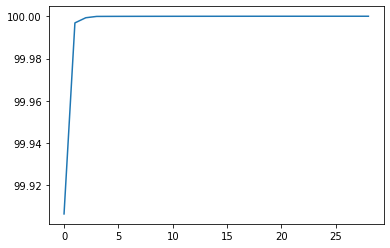

In [65]:
plt.plot(var1)

In [66]:
target=cf_train['Counterfeit_Sales']

In [67]:

# From the above plot selecting 2 components since it explains almost 98+ % data variance
pca = PCA(n_components=4)

# Fitting the selected components to the data
pca.fit(X)

# Using train_test_split sampling function for test and train data split
X_train, X_test, Y_train, Y_test = train_test_split(X,target, test_size=0.2)

In [68]:
rf1=RandomForestRegressor(n_estimators=600,criterion='mse',max_depth=6,bootstrap=True,min_samples_split=2)

In [69]:
rf1.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [70]:

predicted_rf1=rf1.predict(X_test)

In [71]:
mean_absolute_error(Y_test,predicted_rf1)

7.4900110039721515

In [72]:
predicted_rf1

array([2801.35448114,  544.57677859, 2393.49799346, ...,  197.63722227,
       1304.5124203 , 3897.05220756])

In [73]:

list(zip(Y_test,predicted_rf1))

[(2796.1740000000004, 2801.3544811356073),
 (538.4462, 544.576778594889),
 (2394.6966, 2393.4979934576163),
 (1158.306, 1156.8923099728752),
 (3776.2316, 3775.4490296308372),
 (2592.4392, 2586.974954634),
 (4692.3724, 4691.069461592212),
 (3315.498, 3318.5798548397606),
 (2485.9112, 2487.73690208328),
 (3248.918, 3248.4257582864625),
 (832.064, 823.7476333217372),
 (4319.5244, 4336.747748080662),
 (698.904, 715.4758742292593),
 (3463.3056, 3474.6203149494395),
 (1390.0044, 1396.6508482112695),
 (239.502, 231.6961682173396),
 (3119.087, 3110.641148717373),
 (6155.135, 6145.484233300204),
 (4181.038, 4184.081423998875),
 (5641.1374, 5633.422348346017),
 (2872.0752, 2868.4989625534627),
 (2364.0698, 2364.5068391186487),
 (600.3656, 587.3931858644587),
 (3188.996, 3197.9061737074094),
 (2075.7784, 2082.1028577339457),
 (3310.1716, 3314.6130341088697),
 (1966.5872, 1972.2800907878045),
 (915.9548, 910.7030504470428),
 (3268.8920000000007, 3261.881379465427),
 (1527.1592, 1524.4128470553328)